---
**Finite Difference Methods**

Week 19 of EMAT30008

https://engmaths.github.io/emat30008/pdes/finite_diff/

(See scicomp/odefunctions.py for associated functions)

Author: Ben Winstanley, yy23737@bristol.ac.uk

---

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

/Applications/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Goal: Create BVP solver to find solutions to ODEs of form:

$D \frac{d^2 u}{d x^2} + q(x,u:\mu) = 0$

over domain $a \leq x \leq b$, $D > 0$

Solver should handle Dirichlet, Neumann and Robin boundary conditions

Should be compatible with numerical continuation to track how $u(x)$ changes with $\mu$

Should be option to solve with linalg solve or with scipy root

-----------------
Q1: 
Use finite differences to solve
$\frac{d^2 u}{dx^2} = 0, u(a)=\gamma_1, u(b)=\gamma_2$:

We use N many gridpoints, $x_0 = a$, $x_N = b$, $i=0,1,2, \dots ,N-1,N$

Then our grid step is $\Delta x = \frac{b-a}{N}$

We solve:

$u_0 = a$

$\frac{u_{i+1} - 2u_i + u_{i-1}}{(\Delta x)^2}$

$u_N = b$

This becomes solving the matrix equation:

$A^{DD} \vec{u} = -\vec{b}^{DD}$

This would have dimension N-1 for b^DD

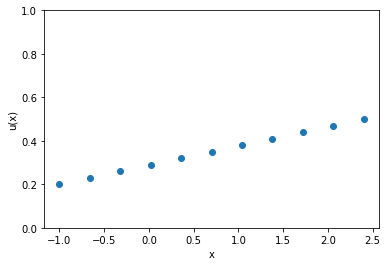

In [34]:
# Choose problem values
a = -1
gamma_1 = 0.2
b = 2.4
gamma_2 = 0.5

# Choose grid size
N = 10
x_vals = np.linspace(a,b,N+1)
delta_x = (b-a)/N

# Construct b^DD with zero plus end points
b_dd = np.zeros([N-1])
b_dd[0] = gamma_1
b_dd[-1] = gamma_2

# Construct A_dd with zeros plus diagonals
A_dd = -2*np.eye(N-1,k=0) + np.eye(N-1,k=1) + np.eye(N-1,k=-1)

# Solve A_dd u = -b_dd with linalg solve
u_interior = np.linalg.solve(A_dd, -b_dd)
# Add interior points to boundary
u = np.concatenate(([gamma_1], u_interior, [gamma_2]))

# Plotting to check
plt.scatter(x_vals,u)
plt.xlabel("x")
plt.ylim([0,1])
plt.ylabel("u(x)")
plt.show()

----------------
Q2: 

Add a prescribed source term q(x)

$A^{DD} \vec{u}(x) = -\vec{b}^{DD} -(\Delta x)^2 q(x)$

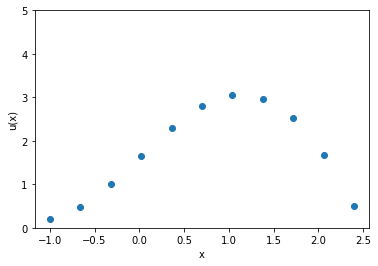

In [44]:
# Add source term q(x) in:
def q_func(x):
    return np.sin(x)

# Establish diffusivity constant D
D = 0.3

# Equation becomes A_dd u = - b_dd - (delta x)^2 q(x)

q_vals = q_func(x_vals)
q_vals_interior = q_vals[1:-1]

# Solve
rhs_vec = -b_dd - ((delta_x**2)/D)*q_vals_interior
u_interior = np.linalg.solve(A_dd, rhs_vec)

u = np.concatenate(([gamma_1], u_interior, [gamma_2]))

# Plotting to check
plt.scatter(x_vals,u)
plt.xlabel("x")
plt.ylim([0,5])
plt.ylabel("u(x)")
plt.show()

-----------------
Q3:

Add dependence on q(u) to make the equation nonlinear

Our equation is:

$A^{DD} \vec{u} = -\vec{b}^{DD} -\frac{(\Delta x)^2}{D} q(\vec u)$

Then we want to find the root of the function:

$F(\vec u) = A^{DD} \vec{u} + \vec{b}^{DD} + \frac{(\Delta x)^2}{D} q(\vec u)$

We define this objective function then use scipy root to find the solution



In [ ]:
# Using same q function but it is now q(u)

def objective(u:np.ndarray):
    q_vals_interior = q_func(u)
    F = np.matmul(A_dd, u) + b_dd + ((delta_x**2)/D)*q_vals_interior
    return F

# Define initial solution guess for root finding which is a line between boundary points
u_guess_full = np.linspace(gamma_1,gamma_2,N+1)
u_guess = u_guess_full[1:-1] # Take the interior